<a href="https://colab.research.google.com/github/thyeaditungson29/mystudy_ADL2022/blob/main/HW_ADL_D2L_chapter_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tugas D2L.AI - Thyeadi Tungson - 2106779554**

**Chapter 5. Deep Learning Computation**

# **5.1. Layers and Blocks**

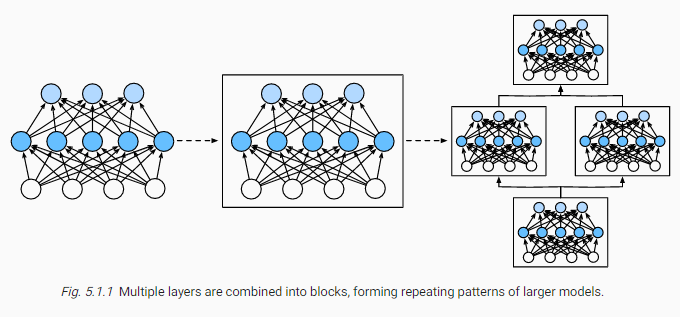

In [1]:
# Inisialisasi
import torch
from torch import nn
from torch.nn import functional as F

net = nn.Sequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))

X = torch.rand(2, 20)
net(X)

tensor([[-0.0626, -0.0430,  0.1252,  0.0686,  0.1048,  0.1121,  0.0258, -0.0240,
          0.1547, -0.1012],
        [-0.1434, -0.0965,  0.2589,  0.2251,  0.1026,  0.1152,  0.0502,  0.0924,
         -0.1848, -0.2015]], grad_fn=<AddmmBackward0>)

**5.1.1. A Custom Block**

In [2]:
class MLP(nn.Module):
    # Declare a layer with model parameters. Here, we declare two fully
    # connected layers
    def __init__(self):
        # Call the constructor of the `MLP` parent class `Module` to perform
        # the necessary initialization. In this way, other function arguments
        # can also be specified during class instantiation, such as the model
        # parameters, `params` (to be described later)
        super().__init__()
        self.hidden = nn.Linear(20, 256)  # Hidden layer
        self.out = nn.Linear(256, 10)  # Output layer

    # Define the forward propagation of the model, that is, how to return the
    # required model output based on the input `X`
    def forward(self, X):
        # Note here we use the funtional version of ReLU defined in the
        # nn.functional module.
        return self.out(F.relu(self.hidden(X)))

In [3]:
net = MLP()
net(X)

tensor([[-0.1379,  0.2670, -0.2999,  0.0179,  0.0750,  0.0629,  0.1154,  0.1502,
          0.0912, -0.0286],
        [-0.1752,  0.2772, -0.2645,  0.0332,  0.0405,  0.0833,  0.0983,  0.2115,
          0.1072, -0.0388]], grad_fn=<AddmmBackward0>)

**5.1.2. The Sequential Block**

In [4]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(args):
            # Here, `module` is an instance of a `Module` subclass. We save it
            # in the member variable `_modules` of the `Module` class, and its
            # type is OrderedDict
            self._modules[str(idx)] = module

    def forward(self, X):
        # OrderedDict guarantees that members will be traversed in the order
        # they were added
        for block in self._modules.values():
            X = block(X)
        return X

In [5]:
net = MySequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))
net(X)

tensor([[-0.0236,  0.0074,  0.0557, -0.1141, -0.0092,  0.1407,  0.0666,  0.0951,
          0.0891,  0.1956],
        [-0.0106,  0.0180,  0.0343, -0.1386, -0.0643,  0.1052,  0.1774,  0.2416,
          0.0261,  0.1351]], grad_fn=<AddmmBackward0>)

**5.1.3. Executing Code in the Forward Propagation Function**

In [6]:
class FixedHiddenMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # Random weight parameters that will not compute gradients and
        # therefore keep constant during training
        self.rand_weight = torch.rand((20, 20), requires_grad=False)
        self.linear = nn.Linear(20, 20)

    def forward(self, X):
        X = self.linear(X)
        # Use the created constant parameters, as well as the `relu` and `mm`
        # functions
        X = F.relu(torch.mm(X, self.rand_weight) + 1)
        # Reuse the fully-connected layer. This is equivalent to sharing
        # parameters with two fully-connected layers
        X = self.linear(X)
        # Control flow
        while X.abs().sum() > 1:
            X /= 2
        return X.sum()

In [7]:
net = FixedHiddenMLP()
net(X)

tensor(-0.3797, grad_fn=<SumBackward0>)

In [8]:
class NestMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(20, 64), nn.ReLU(),
                                 nn.Linear(64, 32), nn.ReLU())
        self.linear = nn.Linear(32, 16)

    def forward(self, X):
        return self.linear(self.net(X))

chimera = nn.Sequential(NestMLP(), nn.Linear(16, 20), FixedHiddenMLP())
chimera(X)

tensor(0.1224, grad_fn=<SumBackward0>)

**5.1.4. Efficiency**

only text to understand, no code to run

# **5.2. Parameter Management**

In [9]:
# Inisialisasi
import torch
from torch import nn

net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 1))
X = torch.rand(size=(2, 4))
net(X)

tensor([[-0.2638],
        [-0.2939]], grad_fn=<AddmmBackward0>)

**5.2.1. Parameter Access**

In [10]:
print(net[2].state_dict())

OrderedDict([('weight', tensor([[ 0.1440,  0.1694, -0.3127, -0.0007, -0.1577,  0.2019, -0.3315,  0.0840]])), ('bias', tensor([-0.2712]))])


*5.2.1.1. Targeted Parameters*

In [11]:
print(type(net[2].bias))
print(net[2].bias)
print(net[2].bias.data)

<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([-0.2712], requires_grad=True)
tensor([-0.2712])


In [12]:
net[2].weight.grad == None

True

*5.2.1.2. All Parameters at Once*

In [13]:
print(*[(name, param.shape) for name, param in net[0].named_parameters()])
print(*[(name, param.shape) for name, param in net.named_parameters()])

('weight', torch.Size([8, 4])) ('bias', torch.Size([8]))
('0.weight', torch.Size([8, 4])) ('0.bias', torch.Size([8])) ('2.weight', torch.Size([1, 8])) ('2.bias', torch.Size([1]))


In [14]:
net.state_dict()['2.bias'].data

tensor([-0.2712])

*5.2.1.3. Collecting Parameters from Nested Blocks*

In [15]:
def block1():
    return nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                         nn.Linear(8, 4), nn.ReLU())

def block2():
    net = nn.Sequential()
    for i in range(4):
        # Nested here
        net.add_module(f'block {i}', block1())
    return net

rgnet = nn.Sequential(block2(), nn.Linear(4, 1))
rgnet(X)

tensor([[-0.5521],
        [-0.5521]], grad_fn=<AddmmBackward0>)

In [16]:
print(rgnet)

Sequential(
  (0): Sequential(
    (block 0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 2): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 3): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=1, bias=True)
)


In [18]:
rgnet[0][1][0].bias.data

tensor([-0.4024, -0.1653,  0.4227,  0.0933,  0.1316,  0.1654, -0.0080,  0.2896])

**5.2.2. Parameter Initialization**

*5.2.2.1. Built-in Initialization*

In [19]:
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01)
        nn.init.zeros_(m.bias)
net.apply(init_normal)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([-0.0079, -0.0009, -0.0061, -0.0056]), tensor(0.))

In [20]:
def init_constant(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 1)
        nn.init.zeros_(m.bias)
net.apply(init_constant)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

In [21]:
def xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
def init_42(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 42)

net[0].apply(xavier)
net[2].apply(init_42)
print(net[0].weight.data[0])
print(net[2].weight.data)

tensor([ 0.3599, -0.6690, -0.1820, -0.0838])
tensor([[42., 42., 42., 42., 42., 42., 42., 42.]])


_5.2.2.2. Custom Initialization_

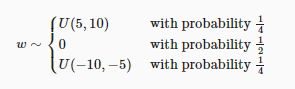

In [22]:
def my_init(m):
    if type(m) == nn.Linear:
        print("Init", *[(name, param.shape)
                        for name, param in m.named_parameters()][0])
        nn.init.uniform_(m.weight, -10, 10)
        m.weight.data *= m.weight.data.abs() >= 5

net.apply(my_init)
net[0].weight[:2]

Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])


tensor([[-0.0000, -6.9092, -5.6989,  9.3568],
        [ 9.5049,  6.6314, -7.7983,  7.5013]], grad_fn=<SliceBackward0>)

In [23]:
net[0].weight.data[:] += 1
net[0].weight.data[0, 0] = 42
net[0].weight.data[0]

tensor([42.0000, -5.9092, -4.6989, 10.3568])

**5.2.3. Tied Parameters**

In [24]:
# We need to give the shared layer a name so that we can refer to its
# parameters
shared = nn.Linear(8, 8)
net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.Linear(8, 1))
net(X)
# Check whether the parameters are the same
print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0, 0] = 100
# Make sure that they are actually the same object rather than just having the
# same value
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


# **5.3. Deferred Initialization**

*Since no code using pytorch, so, in 5.3. session will run in tensorflow*

**5.3.1. Instantiating a Network**

In [25]:
# inisialisasi
import tensorflow as tf

net = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(10),
])

In [26]:
[net.layers[i].get_weights() for i in range(len(net.layers))]

[[], []]

In [27]:
X = tf.random.uniform((2, 20))
net(X)
[w.shape for w in net.get_weights()]

[(20, 256), (256,), (256, 10), (10,)]

# **5.4. Custom Layers**

**5.4.1. Layers without Parameters**

In [28]:
# Inisialisasi
import torch
from torch import nn
from torch.nn import functional as F


class CenteredLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X):
        return X - X.mean()

In [29]:
layer = CenteredLayer()
layer(torch.FloatTensor([1, 2, 3, 4, 5]))

tensor([-2., -1.,  0.,  1.,  2.])

In [30]:
net = nn.Sequential(nn.Linear(8, 128), CenteredLayer())

In [31]:
print(net)

Sequential(
  (0): Linear(in_features=8, out_features=128, bias=True)
  (1): CenteredLayer()
)


In [33]:
Y = net(torch.rand(4, 8))
Y.mean()

tensor(-3.7253e-09, grad_fn=<MeanBackward0>)

**5.4.2. Layers with Parameters**

In [40]:
class MyLinear(nn.Module):
    def __init__(self, in_units, units):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_units, units))
        self.bias = nn.Parameter(torch.randn(units,))
    def forward(self, X):
        linear = torch.matmul(X, self.weight.data) + self.bias.data
        return F.relu(linear)

In [41]:
linear = MyLinear(5, 3)
linear.weight

Parameter containing:
tensor([[-0.4216,  0.0468,  0.6176],
        [ 0.6246, -0.5598,  0.5592],
        [ 0.3947, -0.5968,  0.7036],
        [-0.1600, -1.3909,  0.0245],
        [ 0.1224,  0.3004, -0.3916]], requires_grad=True)

In [42]:
linear(torch.rand(2, 5))

tensor([[1.6376, 0.0000, 0.0000],
        [1.6099, 0.0000, 0.0000]])

In [43]:
net = nn.Sequential(MyLinear(64, 8), MyLinear(8, 1))
net(torch.rand(2, 64))

tensor([[0.],
        [0.]])

# **5.5. File I/O**

**5.5.1. Loading and Saving Tensors**

In [44]:
# Inisialisasi
import torch
from torch import nn
from torch.nn import functional as F

x = torch.arange(4)
torch.save(x, 'x-file')

In [45]:
x2 = torch.load('x-file')
x2

tensor([0, 1, 2, 3])

In [46]:
y = torch.zeros(4)
torch.save([x, y],'x-files')
x2, y2 = torch.load('x-files')
(x2, y2)

(tensor([0, 1, 2, 3]), tensor([0., 0., 0., 0.]))

In [47]:
mydict = {'x': x, 'y': y}
torch.save(mydict, 'mydict')
mydict2 = torch.load('mydict')
mydict2

{'x': tensor([0, 1, 2, 3]), 'y': tensor([0., 0., 0., 0.])}

**5.5.2. Loading and Saving Model Parameters**

In [48]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(20, 256)
        self.output = nn.Linear(256, 10)

    def forward(self, x):
        return self.output(F.relu(self.hidden(x)))

net = MLP()
X = torch.randn(size=(2, 20))
Y = net(X)

In [49]:
torch.save(net.state_dict(), 'mlp.params')

In [50]:
clone = MLP()
clone.load_state_dict(torch.load('mlp.params'))
clone.eval()

MLP(
  (hidden): Linear(in_features=20, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)

In [51]:
Y_clone = clone(X)
Y_clone == Y

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])

# **5.6. GPUs**

**5.6.1. Computing Devices**

In [55]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [52]:
# Inisialisasi
import torch
from torch import nn

torch.device('cpu'), torch.device('cuda'), torch.device('cuda:1')

(device(type='cpu'), device(type='cuda'), device(type='cuda', index=1))

In [54]:
torch.cuda.device_count()

0

In [57]:
def try_gpu(i=0):  #save
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def try_all_gpus():  #save
    """Return all available GPUs, or [cpu(),] if no GPU exists."""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

try_gpu(), try_gpu(10), try_all_gpus()

(device(type='cpu'), device(type='cpu'), [device(type='cpu')])

**5.6.2. Tensors and GPUs**

In [58]:
x = torch.tensor([1, 2, 3])
x.device

device(type='cpu')

*5.6.2.1. Storage on the GPU*

In [59]:
X = torch.ones(2, 3, device=try_gpu())
X

tensor([[1., 1., 1.],
        [1., 1., 1.]])

In [62]:
Y = torch.rand(2, 3, device=try_gpu(1))
Y

tensor([[0.1618, 0.3662, 0.2824],
        [0.6918, 0.2018, 0.2998]])

*5.6.2.2. Copying*

for next step cannot be done, since no **cuda** detect when do the process